# PROJET D'INFORMATIQUE INF442

## Prediction of Signal Peptide Cleavage Site Using Supervised Learning

### Authors :

$\textbf{Nicolas AYONTA TESAHA}$

$\textbf{Armel Randy ZEBAZE DONGMO}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report, roc_auc_score
from sklearn import svm

# DATA EXPLORATION

La cellule suivante est à éxécuter si et seulement si on travaille avec des datasets stockés dans un dossier data, sinon il faudra adapter le chemin. L'on rappelle que les informations sont organisées ligne par ligne. Une protéine est représentée sur trois lignes : une pour sa description de la protéine, une autre pour sa représentation et enfin une dernière pour la position du cleavage site.

In [3]:
data_euksig = pd.read_csv("data/EUKSIG_13.red.txt", delimiter = "\n", header = None)
data_gram_moins = pd.read_csv("data/GRAM+SIG_13.red.txt", delimiter = "\n", header = None)
data_gram_plus = pd.read_csv("data/GRAM-SIG_13.red.txt", delimiter = "\n", header = None)
pd.set_option('display.max_columns', None)

In [ ]:
data_euksig.head(3)

,0
0,50 11S3_HELAN 20 11S GLOBULIN SEED STOR...
1,MASKATLLLAFTLLFATCIARHQQRQQQQNQCQLQNIEALEPIEVI...
2,SSSSSSSSSSSSSSSSSSSSCMMMMMMMMMMMMMMMMMMMMMMMMM...


Le format sous lequel les données sont lues n'est pas satisfaisant, puisque l'on a une seule colonne alors qu'on aurait voulu 3, pour régler cela on va rédiger quelques fonctions.

In [ ]:
def cleaning(dataset):
    # repartition en trois colonnes
    m = int(dataset.shape[0]/3)
    description = []
    primary_structure = []
    cleavage_site = []
    for i in range(m):
        description.append(dataset.iloc[3*i, 0])
        primary_structure.append(dataset.iloc[3*i+1, 0])
        cleavage_site.append(dataset.iloc[3*i+2, 0])
    resultat = pd.DataFrame(list(zip(description, primary_structure, cleavage_site)), columns = 
                           ['Description', 'Primary structure', 'Cleavage site'])
    return resultat

In [ ]:
data_euk = cleaning(data_euksig)
data_moins = cleaning(data_gram_moins)
data_plus = cleaning(data_gram_plus)

In [ ]:
data_euk.head(3)

,Description,Primary structure,Cleavage site
0,50 11S3_HELAN 20 11S GLOBULIN SEED STOR...,MASKATLLLAFTLLFATCIARHQQRQQQQNQCQLQNIEALEPIEVI...,SSSSSSSSSSSSSSSSSSSSCMMMMMMMMMMMMMMMMMMMMMMMMM...
1,51 11SB_CUCMA 21 11S GLOBULIN BETA SUBU...,MARSSLFTFLCLAVFINGCLSQIEQQSPWEFQGSEVWQQHRYQSPR...,SSSSSSSSSSSSSSSSSSSSSCMMMMMMMMMMMMMMMMMMMMMMMM...
2,54 1B39_HUMAN 24 HLA CLASS I HISTOCOMPA...,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,SSSSSSSSSSSSSSSSSSSSSSSSCMMMMMMMMMMMMMMMMMMMMM...


Là c'est mieux, nous avons effectivement trois colonnes correspondant respectivement a la description de la protéine, sa structure primare et la position du cleavage site.

In [ ]:
# Alphabet sur lequel on travaille.
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

L'on étudie un problème de classification. Étant donnée une protéine $(a_i)_{i=0,...,l−1}$, et une position $j$, où $p ≤ j ≤ l−q$, le mot $a_{j−p}a_{j−p+1} · · · a_{j−1}a_{j} · · · a_{j+q−1}$ ∈ $A^{p+q}$, avec $A$ l'alphabet.

On va ajouter d'autres informations à notre DataFrame, en occurence pour chaque protéine on va indiquer sa taille et la position (indice) du cleavage site.

In [ ]:
def add_column(dataset):
    # ajout des colonnes taille et l'indice à la droite du cleavage site 
    data = dataset.copy()
    data['Longueur'] = [len(data['Primary structure'][i]) for i in range(data.shape[0])]
    data['Indice droit'] = [data['Cleavage site'][i].find('C') for i in range(data.shape[0])]
    data = data.drop(columns = ['Description', 'Cleavage site'])
    return data

In [ ]:
data_euk = add_column(data_euk)
data_plus = add_column(data_plus)
data_moins = add_column(data_moins)

In [ ]:
data_euk.head(3)

,Primary structure,Longueur,Indice droit
0,MASKATLLLAFTLLFATCIARHQQRQQQQNQCQLQNIEALEPIEVI...,50,20
1,MARSSLFTFLCLAVFINGCLSQIEQQSPWEFQGSEVWQQHRYQSPR...,51,21
2,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,54,24


L'on affiche les indices minimaux des sites de cleavage pour voir jusqu'à quel voisinage on pourra arriver pour les données à notre disposition.

In [ ]:
print("Indice minimaux et maximaux des sites de Cleavage")
print("EUK")
print(data_euk['Indice droit'].min()) 
print((data_euk['Longueur'] - data_euk['Indice droit']).min())
print("PLUS")
print(data_plus['Indice droit'].min())
print((data_plus['Longueur'] - data_plus['Indice droit']).min())
print("MOINS")
print(data_moins['Indice droit'].min())
print((data_moins['Longueur'] - data_moins['Indice droit']).min())

Indice minimaux et maximaux des sites de Cleavage
EUK
13
30
PLUS
14
30
MOINS
22
30


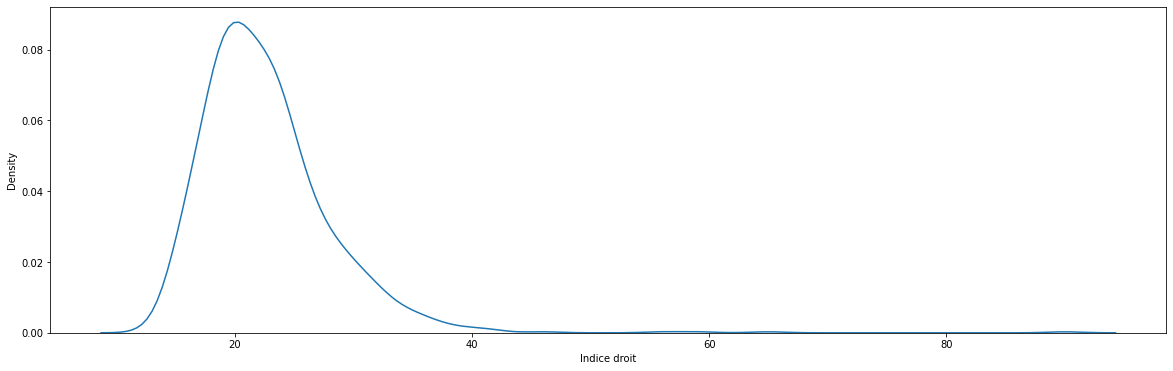

In [ ]:
#data_euk['Indice droit'].value_counts()
plt.figure(figsize = (20, 6))
sns.histplot(data = data_euk, x = "Indice droit")
#sns.kdeplot(data = data_euk, x = "Indice droit")

# Simple Statistical Model Using a Position-Specific Scoring Matrix : Preprocessing

$frequence_{i} = \frac{N_i}{N}$.
$\tilde{frequence_{i}} = \frac{N_i + parametrelog}{N+parametrelog*card(I)}$. Parametrelog permet d'éviter les fréquences nulles.

In [ ]:
parametre_log = 1 # parametre de normalisation

a = nombre de voisins de gauche
b = nombre de voisins de droite

In [ ]:
# hyperparametres de test
a = 13
b = 2

La fonction suivante permet de creer la matrice $F = (f(a,i))_{i = -p ... q-1}{a \in A}$

In [ ]:
def counting(data, p, q):
    # occurence normalisée de chaque caractère à chaque position
    # somme sur une ligne  = somme sur une colonne = 1
    colonnes = [i for i in range(-p, q)]
    data_test = pd.DataFrame(0, index = alphabet, columns = colonnes)
    for caractere in alphabet:
        for i in colonnes :
            somme = 0
            for k in range(data.shape[0]):
                mot = data['Primary structure'][k]
                indice = data['Indice droit'][k]
                if(mot[indice+i] == caractere):
                    somme = somme + 1
            data_test.loc[caractere, i] = somme
    return (data_test + parametre_log)/(data.shape[0] + parametre_log*len(alphabet))

Test effectué sur EUKSIG.

In [ ]:
F_euk = counting(data_euk, a, b)

In [ ]:
F_euk

,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1
A,0.098933,0.109602,0.103783,0.096993,0.153249,0.125121,0.104753,0.145490,0.141610,0.103783,0.249273,0.078565,0.443259,0.135790,0.054316
B,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970
C,0.035887,0.032008,0.033948,0.031038,0.041707,0.064016,0.056256,0.038797,0.030068,0.033948,0.066925,0.021339,0.049467,0.023278,0.027158
D,0.002910,0.000970,0.002910,0.000970,0.003880,0.002910,0.004850,0.005820,0.025218,0.014549,0.004850,0.043647,0.006790,0.066925,0.064985
E,0.001940,0.002910,0.004850,0.005820,0.004850,0.006790,0.012609,0.009699,0.028128,0.027158,0.007759,0.064985,0.005820,0.089234,0.086324
F,0.072745,0.065955,0.078565,0.079534,0.064016,0.057226,0.089234,0.064985,0.024248,0.033948,0.005820,0.045587,0.006790,0.033948,0.028128
G,0.038797,0.024248,0.026188,0.033948,0.035887,0.049467,0.039767,0.029098,0.105723,0.122211,0.072745,0.037827,0.178468,0.051406,0.056256
H,0.005820,0.003880,0.004850,0.002910,0.004850,0.010669,0.014549,0.007759,0.023278,0.012609,0.005820,0.052376,0.002910,0.023278,0.022308
I,0.071775,0.065955,0.079534,0.057226,0.051406,0.051406,0.046557,0.067895,0.021339,0.042677,0.040737,0.018429,0.004850,0.035887,0.033948
J,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970,0.000970


In [ ]:
def occurence_compte(data):
    # Frequence de chaque caractère dans le dataset
    data_occurence = pd.DataFrame(0, index = alphabet, columns = ['Compte'])
    for caractere in alphabet :
        somme = 0
        for k in range(data.shape[0]):
            mot = data['Primary structure'][k][1:] 
            somme = somme + mot.count(caractere)
        data_occurence.loc[caractere, 'Compte'] = somme
    data_occurence = (data_occurence + parametre_log)
    return data_occurence

La fonction suivante permet de creer le vecteur $G =  g(a)_{a \in A}$

In [ ]:
def occurence_simple(data):
    # Frequence de chaque caractère dans le dataset
    data_occurence = pd.DataFrame(0, index = alphabet, columns = ['Compte'])
    for caractere in alphabet :
        somme = 0
        for k in range(data.shape[0]):
            mot = data['Primary structure'][k][1:] 
            somme = somme + mot.count(caractere)
        data_occurence.loc[caractere, 'Compte'] = somme
    data_occurence = (data_occurence + parametre_log)/(np.sum(data['Longueur']) - data.shape[0] + parametre_log*len(alphabet))
    return data_occurence

Test effectué sur EUKSIG.

In [ ]:
G_euk = occurence_simple(data_euk)

In [ ]:
G_euk

,Compte
A,0.092829
B,0.000019
C,0.034062
D,0.035776
E,0.046020
F,0.042496
G,0.067316
H,0.018601
I,0.042015
J,0.000019


In [ ]:
np.sum(G_euk['Compte']) # vérification si c'est une loi de probabilité

1.0

In [ ]:
def finale(F, G):
  return np.log(F) - np.log(G).values

test effectué sur EUKSIG.

In [ ]:
S_euk = finale(F_euk, G_euk)

In [ ]:
S_euk

,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1
A,0.063681,0.166096,0.111537,0.043878,0.501303,0.298520,0.120839,0.449343,0.422314,0.111537,0.987784,-0.166843,1.563391,0.380350,-0.535940
B,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444
C,0.052193,-0.062218,-0.003377,-0.092989,0.202475,0.630930,0.501718,0.130154,-0.124738,-0.003377,0.675381,-0.467683,0.373100,-0.380671,-0.226521
D,-2.509199,-3.607811,-2.509199,-3.607811,-2.221517,-2.509199,-1.998374,-1.816052,-0.349715,-0.899761,-1.998374,0.198851,-1.661901,0.626295,0.596881
E,-3.166457,-2.760992,-2.250166,-2.067845,-2.250166,-1.913694,-1.294655,-1.557019,-0.492308,-0.527400,-1.780163,0.345088,-2.067845,0.662184,0.629032
F,0.537543,0.439563,0.614504,0.626774,0.409710,0.297593,0.741844,0.424748,-0.561069,-0.224597,-1.988185,0.070203,-1.834035,-0.224597,-0.412649
G,-0.551051,-1.021054,-0.944093,-0.684582,-0.629012,-0.308105,-0.526358,-0.838733,0.451418,0.596352,0.077558,-0.576369,0.975005,-0.269638,-0.179487
H,-1.161960,-1.567425,-1.344281,-1.855107,-1.344281,-0.555824,-0.245669,-0.874278,0.224334,-0.388770,-1.161960,1.035265,-1.855107,0.224334,0.181775
I,0.535512,0.450955,0.638167,0.308985,0.201739,0.201739,0.102648,0.479943,-0.677510,0.015637,-0.030883,-0.824114,-2.159115,-0.157635,-0.213205
J,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444,3.919444


Cette fonction renvoie, pour un dataset donné renvoie un autre de meme nombre de ligne et tel que :
$ligne_i = \sum_{i = -p}^{q-1}S[a[p+i], i]$

In [ ]:
def calcul_global(data, S, p, q):
    target = pd.DataFrame(0, index = np.arange(data.shape[0]), columns = ['site'])
    for i in range(data.shape[0]):
        mot = data.loc[i, 'Primary structure']
        indice = data.loc[i, 'Indice droit']
        somme = 0
        for j in range(-p, q):
            somme = S.loc[mot[j+indice], j]
        target.loc[i, 'site'] = somme
    return target

Test effectué sur EUKSIG.

In [ ]:
target_euk = calcul_global(data_euk, S_euk, a, b)

In [ ]:
target_euk

,site
0,0.181775
1,-0.213205
2,0.039287
3,1.056211
4,-0.213205
...,...
1000,-0.535940
1001,0.629032
1002,-0.213205
1003,-0.041028


Cette fonction regroupe le calcul de F, G et S pour un voisinage (p, q) donné.

In [ ]:
def preprocessing(data, p, q):
  # dataset apres add_column, donc ses colonnes sont ['Primary structure','Indice droit','Longueur']
  # return S
  F = counting(data, p, q)
  G = occurence_simple(data)
  S = finale(F, G)
  return S

Pareil que preprocessing, sauf que calcul_global est fait en plus.

In [ ]:
def preprocessing_1(data, p, q):
  # data apres add_column, donc ses colonnes sont ['Primary structure','Indice droit','Longueur']
  # va jusqu'a calcul_global
  F = counting(data, p, q)
  G = occurence_simple(data)
  S = finale(F, G)
  return calcul_global(data, S, p, q)

# COUPLE OF FUNCTIONS

Cette fonction transforme un caractère en one - hot vector $\in \mathbb{R}^{26}$

In [ ]:
def find_indice(caractere):
    #renvoie un vecteur (26, 1)
    for i in range(len(alphabet)):
        if caractere == alphabet[i] :
            indice = i
    retour = np.zeros((len(alphabet), 1))
    retour[indice] = 1
    return retour

In [ ]:
Gc_euk = occurence_compte(data_euk)

In [ ]:
def find_spe(caractere, Gc):
  v = find_indice(caractere)
  ind = np.where(v == 1)[0][0]
  v[ind] = Gc.loc[caractere, "Compte"]
  return v

In [ ]:
#print(find_indice('A'))

La fonction suivante permet, étant donné un mot, de trouver sa représentation vectorielle grâce à celle de ses caractères.

In [ ]:
def find_representation(mot):
    resultat = find_indice(mot[0])
    for i in range(1, len(mot)):
        resultat = np.concatenate((resultat, find_indice(mot[i])), axis = 0)  
    return resultat.T

In [ ]:
def find_representation_spe(mot, Gc):
    resultat = find_spe(mot[0], Gc)
    for i in range(1, len(mot)):
        resultat = np.concatenate((resultat, find_spe(mot[i], Gc)), axis = 0)  
    return resultat.T

In [ ]:
#print(find_representation('ABC').shape)

Cette fonction crée la matrice mot - representation vectorielle du DataFrame pris en paramètre.

In [ ]:
def one_hot_matrix(data, p, q):
    resultat = pd.DataFrame(0, index = np.arange(data.shape[0]), columns = np.arange((p+q)*len(alphabet)))
    for i in range(data.shape[0]):
        indice = data['Indice droit'][i]
        mot = data['Primary structure'][i]
        matrice = find_representation(mot[indice-p:indice+q])
        for j in range(resultat.shape[1]):
            resultat.iloc[i][j] = matrice[0][j]
    return resultat

In [ ]:
def oh_spe(data, p, q):
    resultat = pd.DataFrame(0, index = np.arange(data.shape[0]), columns = np.arange((p+q)*len(alphabet)))
    Gc_d = occurence_compte(data)
    for i in range(data.shape[0]):
        indice = data['Indice droit'][i]
        mot = data['Primary structure'][i]
        matrice = find_representation_spe(mot[indice-p:indice+q], Gc_d)
        for j in range(resultat.shape[1]):
            resultat.iloc[i][j] = matrice[0][j]
    return resultat

Test effectué sur EUKSIG.

In [ ]:
one_hot_matrix(data_euk, a, b)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

La fonction suivante est d'une importance capitale. Nous sommes en apprentissage supervisé, le problème est que nous ne possedons que les données avec les bons site de cleavage (labelisés 1). Pour que l'apprentissage puisse se faire de la bonne manière, il faut que nos moèeles puissent reconnaitre des sites qui ne sont pas des sites de cleavage. La fonction suivante permet donc de générer, à partir d'un dataset avec de bon site de cleavage, un autre dataset avec les mêmes protéines mais des sites de cleavage différents des vrais, qui seront donc labelisés 0. Plus tard on creera l'ensemble d'apprentissage en concatenant le dataset normal et celui créé par cette fonction.

In [ ]:
def choix (data_, p, q):
    # pour l'entrainement
    n = data_.shape[0]
    data = data_.copy()
    data = data.drop(columns = ['Cleavage site'], errors = 'ignore')
    for i in range(n):
        pr = data.loc[i, 'Indice droit']
        l = data.loc[i, 'Longueur']
        v = np.arange(p, l-q+1)
        v = np.delete(v, pr-p)
        data.loc[i, 'Indice droit'] = np.random.choice(v, 1)[0]
    return data

In [ ]:
data_euk_augmented = choix(data_euk, a, b)

In [ ]:
data_euk_augmented

,Primary structure,Longueur,Indice droit
0,MASKATLLLAFTLLFATCIARHQQRQQQQNQCQLQNIEALEPIEVI...,50,46
1,MARSSLFTFLCLAVFINGCLSQIEQQSPWEFQGSEVWQQHRYQSPR...,51,35
2,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,54,14
3,MKLSKSTLVFSALLVILAAASAAPANQFIKTSCTLTTYPAVCEQSL...,52,37
4,MANKLFLVCATLALCFLLTNASIYRTVVEFEEDDASNPVGPRQRCQ...,51,13
...,...,...,...
1000,MKVTAASAGLLGHAFAAPVPQPVLVSRSAGINYVQNYNGNLADFTY...,57,44
1001,MVPVLLSLLLLLGPAVPQENQDGRYSLTYIYTGLSKHVEDVPAFQAL,47,29
1002,MATKILSLLALLALFASATNASIIPQCSLAPSSIIPQFLPPVTSMA...,51,13
1003,MKVLIVALALLALAASAASSTSGGCGCQTPPFHLPPPFYMPPPFYLPPQ,49,29


Permet de tester s'il y'a des indices redondants. Normalement ca doit renvoyer un dataset vide.

In [ ]:
def test_random(data, a, b):
  temp = choix(data, a, b)
  return temp[temp['Indice droit'] == data['Indice droit']]

In [ ]:
test_random(data_euk, a, b)

,Primary structure,Longueur,Indice droit


Cette fonction renvoie l'ensemble d'entrainement pour le modele statistique.

In [ ]:
def build_training_stat(data, a, b):
  temp1 = preprocessing_1(data, a, b)
  S = preprocessing(data, a, b)
  temp2 = choix(data, a, b)
  temp2 = calcul_global(temp2, S, a, b)
  temp1['Label'] = 1
  temp2['Label'] = 0
  return pd.concat([temp1, temp2]).reset_index(drop = True)

In [ ]:
X_stat_euk = build_training_stat(data_euk, a, b)

Calcule le vecteur des $\sum_{i = -p}^{q-1}S[a[p+i], i]$ pour le dataset $\textbf{data}$ en utilisant le $S$ de train.

In [ ]:
def exemple(train, data, a, b):
  S = preprocessing(train, a, b)
  temp1 = calcul_global(data, S, a, b)
  temp1['Label'] = 1
  temp2 = choix(data, a, b)
  temp2 = calcul_global(temp2, S, a, b)
  temp2['Label'] = 0
  return pd.concat([temp1, temp2]).reset_index(drop = True)

Cette fonction cree l'ensemble d'apprentissage pour le modele avec encodage one-hot.

In [ ]:
def build_training(data, a, b):
  data1 = one_hot_matrix(data, a, b)
  data2 = one_hot_matrix(choix(data, a, b), a, b)
  data1['Label'] = 1
  data2['Label'] = 0
  return pd.concat([data1, data2]).reset_index(drop = True)

In [ ]:
def bts(data, a, b):
  data1 = oh_spe(data, a, b)
  data2 = oh_spe(choix(data, a, b), a, b)
  data1['Label'] = 1
  data2['Label'] = 0
  return pd.concat([data1, data2]).reset_index(drop = True)

In [ ]:
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()

In [ ]:
X_euk = build_training(data_euk, a, b)
#X_euk = bts(data_euk, a, b)

In [ ]:
X_euk

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,Label
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0

Divise le dataset en $X, y$.

In [ ]:
def split(X):
  return  X.drop(columns = ['Label']), X['Label']

In [ ]:
X_train, y_train = split(X_euk)

In [ ]:
train_X, train_y = split(X_stat_euk)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

In [ ]:
X_train_ = X_train*(1+np.sqrt(4))/2
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train_, y_train, test_size = 0.2)

Permet de tracer la courbe roc du classifier apres validation croisée.

In [ ]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Permet de tracer la courbe qui permet d'observer le trade-off entre la precision et le recall en fonction des seuils choisis pour la prediction.

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])

# Simple Statistical Model Using a Position-Specific Scoring Matrix : Training and Tuning

Il est question d'établir un simple modèle statistique de sorte à constuire un prédicteur de la forme : 
$\hat{Y} = \mathbb{1}_{X > seuil}$ avec $X = \sum_{i = -p}^{q-1}s(a_{p+i}, i)$ et $(a_i)_{i=0,...,l−1}$ le mot surlequel on applique le prédicteur.

Pour trouver une valeur satisfaisante du seuil, on va se servir du dataset EUKSIG_13 et on évaluera sa pertinence sur GRAM+SIG_13 et GRAM-SIG_13. Une première intention est d'utiliser la moyenne empirique, et en fonction des resultats obtenus on réajuste à un facteur près.

In [ ]:
def predire(op, seuil):
  res = op['site'].apply(lambda x : x > seuil).astype(int)
  return res

on utilise le $S$ de EUKSIG pour calculer $\sum_{i = -p}^{q-1}S[a[i+p], i]$ pour data_plus et data_moins.

In [ ]:
plus_X = exemple(data_euk, data_plus, a, b)
moins_X = exemple(data_euk, data_moins, a, b)

In [ ]:
moyenne = np.mean(target_euk)

In [ ]:
moyenne

site    0.155873
dtype: float64

In [ ]:
for p in [-1, -1/2, -1/4, -1/8, 0, 1/8, 1/4, 1/2, 1]:
  seuil = p*moyenne
  print("Threshold : " + str(seuil))
  print("\n\n")
  print("---------------------------------------------------------------------------------------------------")
  print("Test sur le dataset original : \n")
  v = train_y.values
  t = predire(train_X, seuil).values
  #print(precision_score(v, t))
  #print(recall_score(v,t))
  #print(f1_score(v,t))
  print(classification_report(v, t))
  print("---------------------------------------------------------------------------------------------------")
  print("Test sur data_plus : \n")
  v1 = plus_X['Label']
  t1 = predire(plus_X, seuil)
  #print(precision_score(v1, t1))
  #print(recall_score(v1,t1))
  #print(f1_score(v1,t1))
  print(classification_report(v1, t1))
  print("---------------------------------------------------------------------------------------------------")
  print("Test sur data_moins : \n")
  v2 = moins_X['Label']
  t2 = predire(moins_X, seuil)
  #print(precision_score(v2, t2))
  #print(recall_score(v2,t2))
  #print(f1_score(v2,t2))
  print(classification_report(v2, t2))
  print("\n")

Un bon seuil est la $\frac{moyenne}{8}$


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


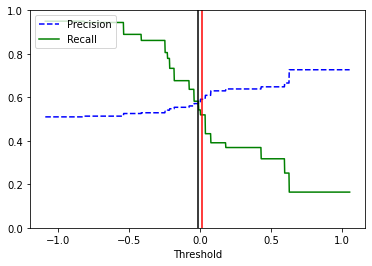

In [ ]:
dim = 1000
x_ = np.linspace(np.min(target_euk), np.max(target_euk), dim)
precision_ = np.zeros((dim,1))
recall_ = np.zeros((dim,1))
for i in range(dim):
  s = x_[i]
  v = train_y
  t = predire(train_X, s)
  recall_[i] = recall_score(v,t)
  precision_[i] = precision_score(v,t)
plot_precision_recall_vs_threshold(precision_, recall_, x_[:-1])
plt.axvline(x = 0.019184, c = 'r')
plt.axvline(x = -0.0095, c = 'k')
plt.show()

In [ ]:
opt = -0.0095

Cette fonction effectue la prediction avec le modele statistique en prenant un ensemble d'apprentissage, son S, les limites du voisinage et le seuil de prediction.

In [ ]:
def prediction_statistique(S, p, q, seuil, test):
  n = test.shape[0]
  temp = pd.DataFrame(0, index = np.arange(n), columns = ['site'])
  for i in range(n):
    mot = test.loc[i, 'Primary structure']
    indice = test.loc[i, 'Indice droit']
    somme = 0
    for j in range(-p, q):
      somme = somme + S.loc[mot[indice + j] ,j]
    temp.loc[i, 'site'] = int((somme > seuil))
  return temp

# SOME SVM KERNELS

L'idée ici est d'utiliser l'algorithme des séparateurs à vastes marges avec des kernels personnalisés. Pour ce faire il faut trouver un moyen de représentation vectorielle des protéines.

precision = $\frac{TP}{TP+FP}$
recall = $\frac{TP}{TP+FN}$

### SVM GAUSSIAN KERNEL

In [ ]:
def gaussian_tune(X, y):
  parametres_rbf = [
    {
        'gamma':[0.5, 0.1, 1, 5, 10],
        'C':[0.01, 0.1, 0.5, 1, 5, 10],
        'kernel':['rbf']
    }
  ]
  model_rbf = svm.SVC(cache_size = 1000)
  model_1 = GridSearchCV(model_rbf, parametres_rbf, cv = 3, n_jobs = -1, verbose = 2, scoring = 'f1')
  model_1.fit(X, y)
  print("Best parameters : ")
  print(model_1.best_params_)
  return model_1.best_estimator_

In [ ]:
model_1 = gaussian_tune(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   55.4s finished


Best parameters : 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
model_1_ = gaussian_tune(X_train_, y_train_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   35.2s finished


Best parameters : 
{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
y_s_1 = cross_val_predict(model_1, X_train, y_train, cv = 3, method = "decision_function")

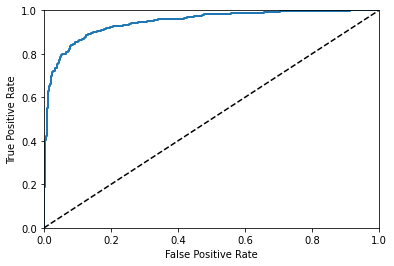

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_s_1)
plot_roc_curve(fpr, tpr, label = None)

In [ ]:
y_s_1_ = cross_val_predict(model_1_, X_train_, y_train_, cv = 3, method = "decision_function")

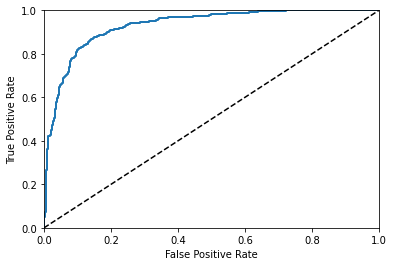

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_, y_s_1_)
plot_roc_curve(fpr, tpr, label = None)

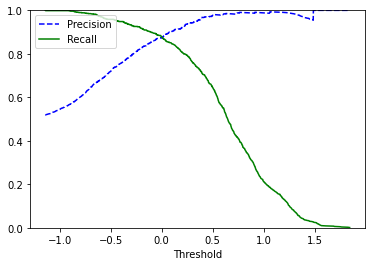

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_s_1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
y_train_pred_1 = model_1.predict(X_train) #cross_val_predict(model_1, X_train, y_train, cv = 3)

In [ ]:
print(classification_report(y_train, y_train_pred_1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       811
           1       0.99      0.99      0.99       797

    accuracy                           0.99      1608
   macro avg       0.99      0.99      0.99      1608
weighted avg       0.99      0.99      0.99      1608



Le modèle overfit naturellement sur l'ensemble d'apprentissage.

In [ ]:
y_pred_1 = model_1.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred_1))

[[169  25]
 [ 29 179]]


In [ ]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       194
           1       0.88      0.86      0.87       208

    accuracy                           0.87       402
   macro avg       0.87      0.87      0.87       402
weighted avg       0.87      0.87      0.87       402



Il n'y a pas de différences notables entre les performances du modèle sur la classe 1 et sur la classe 0.

### SVM POLYNOMIAL KERNEL

In [ ]:
def poly_tune(X_train, y_train):
  parametres_poly = [
      {
          'gamma':[1, 0.1, 0.05, 0.01],
          'C':[0.01, 0.1, 1, 10],
          'degree':[1, 2, 3],
          'coef0': [1, 2],
          'kernel':['poly']
      }
  ]
  model_poly = svm.SVC(cache_size = 1000)
  model_2 = GridSearchCV(model_poly, parametres_poly, cv = 3, n_jobs = -1, verbose = 2, scoring = 'f1')
  model_2.fit(X_train, y_train)
  print("Best parameters : ")
  print(model_2.best_params_)
  return model_2.best_estimator_

In [ ]:
model_2 = poly_tune(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.0min finished


Best parameters : 
{'C': 0.1, 'coef0': 2, 'degree': 2, 'gamma': 0.05, 'kernel': 'poly'}


In [ ]:
y_s_2 = cross_val_predict(model_2, X_train, y_train, cv = 3, method = "decision_function")

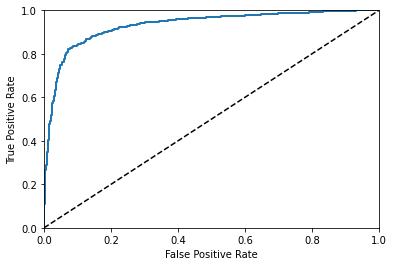

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_s_2)
plot_roc_curve(fpr, tpr, label = None)

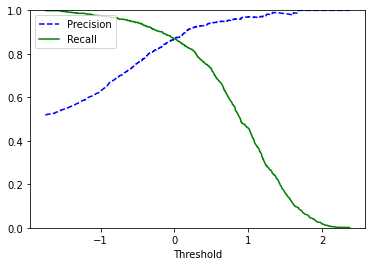

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_s_2)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
y_train_pred_2 = model_2.predict(X_train) #cross_val_predict(model_2, X_train, y_train, cv = 3)

In [ ]:
print(classification_report(y_train, y_train_pred_2))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       800
           1       0.91      0.89      0.90       808

    accuracy                           0.90      1608
   macro avg       0.90      0.90      0.90      1608
weighted avg       0.90      0.90      0.90      1608



Ce modèle overfit moins l'ensemble d'apprentissage.

In [ ]:
y_pred_2 = model_2.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred_2))

[[178  27]
 [ 26 171]]


In [ ]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       205
           1       0.86      0.87      0.87       197

    accuracy                           0.87       402
   macro avg       0.87      0.87      0.87       402
weighted avg       0.87      0.87      0.87       402



De meme les performances sur les classes 0 et 1 sont similaires.

### SVM LINEAR KERNEL

In [ ]:
def linear_tune(X_train, y_train):
  parametres_linear = [
      {
          'gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10],
          'C':[0.005, 0.01, 0.1, 1, 10],
          'kernel':['linear']
      }
  ]
  model_linear = svm.SVC(cache_size = 1000)
  model_3 = GridSearchCV(model_linear, parametres_linear, cv = 3, n_jobs = -1, verbose = 2,scoring = 'f1')
  model_3.fit(X_train, y_train)
  print("Best parameters : ")
  print(model_3.best_params_)
  return model_3.best_estimator_

In [ ]:
model_3 = linear_tune(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   31.9s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}


In [ ]:
y_s_3 = cross_val_predict(model_3, X_train, y_train, cv = 3, n_jobs = -1, method = "decision_function")

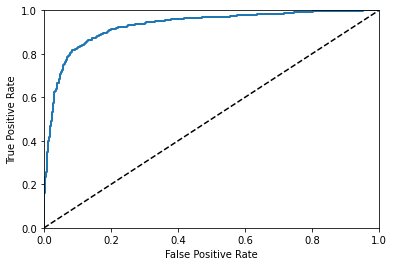

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_s_3)
plot_roc_curve(fpr, tpr, label = None)

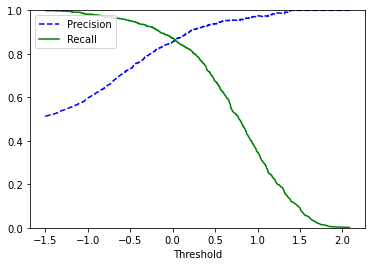

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_s_3)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
y_train_pred_3 = model_3.predict(X_train) #cross_val_predict(model_3, X_train, y_train, cv = 3)

In [ ]:
print(classification_report(y_train, y_train_pred_3))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       800
           1       0.88      0.88      0.88       808

    accuracy                           0.88      1608
   macro avg       0.88      0.88      0.88      1608
weighted avg       0.88      0.88      0.88      1608



Ce modele overfit encore moins l'ensemble d'apprentissage.

In [ ]:
y_pred_3 = model_3.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred_3))

[[173  32]
 [ 25 172]]


In [ ]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       205
           1       0.84      0.87      0.86       197

    accuracy                           0.86       402
   macro avg       0.86      0.86      0.86       402
weighted avg       0.86      0.86      0.86       402



Les performances sont similaires sur les classes 0 et 1, il fait moins bien que les autres kernels.

# OTHER KERNELS

### BLOSUM KERNEL

Colonnes de la matrice Blosum62

In [ ]:
cols = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*', 'J', 'O', 'U']

In [ ]:
Blosum62 = pd.DataFrame(0, index = cols , columns = cols)

In [ ]:
Blosum62['A'] = [  4, -1, -2, -2, 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1,  1, 0, -3, -2, 0, -2, -1, 0, -4, 0, 0, 0]
Blosum62['R'] = [-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2,  2, -1, -3, -2, -1, -1, -3, -2, -3, -1, 0, -1, -4, 0, 0, 0]
Blosum62['N'] = [-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2,  1, 0, -4, -2, -3, 3, 0, -1, -4, 0, 0, 0] 
Blosum62['D'] = [-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3, 4, 1, -1, -4, 0, 0, 0] 
Blosum62['C'] = [0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1, -3, -3, -2, -4, 0, 0, 0] 
Blosum62['Q'] = [-1, 1, 0, 0, -3, 5, 2, -2, 0, -3, -2, 1,  0, -3, -1,  0, -1, -2, -1, -2, 0, 3, -1, -4, 0, 0, 0] 
Blosum62['E'] = [-1, 0, 0, 2, -4, 2, 5, -2,  0, -3, -3,  1, -2, -3, -1, 0, -1, -3, -2, -2, 1, 4, -1, -4, 0, 0, 0] 
Blosum62['G'] = [ 0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3, -1, -2, -1, -4, 0, 0, 0] 
Blosum62['H'] = [-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3, 0, 0, -1, -4, 0, 0, 0]
Blosum62['I'] = [-1, -3, -3, -3, -1, -3, -3, -4, -3, 4,  2, -3,  1, 0, -3, -2, -1, -3, -1, 3, -3, -3, -1, -4, 0, 0, 0]
Blosum62['L'] = [-1, -2,-3, -4,-1, -2, -3, -4, -3,  2,  4, -2,  2,  0, -3, -2, -1, -2, -1, 1, -4, -3, -1, -4, 0, 0, 0] 
Blosum62['K'] = [-1,  2, 0, -1, -3, 1,  1, -2, -1, -3, -2,  5, -1, -3, -1,  0, -1, -3, -2, -2, 0, 1, -1, -4, 0, 0, 0] 
Blosum62['M'] = [-1, -1,-2, -3, -1, 0, -2, -3, -2,  1,  2, -1,  5, 0, -2, -1, -1, -1, -1, 1, -3, -1, -1, -4, 0, 0, 0] 
Blosum62['F'] = [-2, -3, -3, -3, -2, -3, -3, -3, -1,  0,  0, -3,  0,  6, -4, -2, -2, 1, 3, -1, -3, -3, -1, -4, 0, 0, 0] 
Blosum62['P'] = [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4,  7, -1, -1, -4, -3, -2, -2, -1, -2, -4, 0, 0, 0] 
Blosum62['S'] = [1, -1, 1, 0, -1,  0,  0,  0, -1, -2, -2,  0, -1, -2, -1,  4, 1, -3, -2, -2, 0, 0, 0, -4, 0, 0, 0] 
Blosum62['T'] = [0, -1,  0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 1,  5, -2, -2, 0, -1, -1, 0, -4, 0, 0, 0] 
Blosum62['W'] = [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3, -4, -3, -2, -4, 0, 0, 0] 
Blosum62['Y'] = [-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2, 2, 7, -1, -3, -2, -1, -4, 0, 0, 0] 
Blosum62['V'] = [0, -3, -3, -3, -1, -2, -2, -3, -3, 3, 1, -2,  1, -1, -2, -2, 0, -3, -1, 4, -3, -2, -1,-4, 0, 0, 0] 
Blosum62['B'] = [-2, -1, 3, 4, -3, 0, 1, -1, 0, -3, -4,  0, -3, -3, -2, 0, -1, -4, -3, -3, 4, 1, -1, -4, 0, 0, 0] 
Blosum62['Z'] = [-1,  0,  0,  1, -3,  3,  4, -2,  0, -3, -3,  1, -1, -3, -1, 0, -1, -3, -2, -2, 1,  4, -1, -4, 0, 0, 0] 
Blosum62['X'] = [0, -1, -1, -1, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -2, 0, 0, -2, -1, -1, -1, -1, -1, -4, 0, 0, 0] 
Blosum62['*'] = [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, 1, 0, 0, 0]

In [ ]:
Blosum62

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V,B,Z,X,*,J,O,U
A,4,-1,-2,-2,0,-1,-1,0,-2,-1,-1,-1,-1,-2,-1,1,0,-3,-2,0,-2,-1,0,-4,0,0,0
R,-1,5,0,-2,-3,1,0,-2,0,-3,-2,2,-1,-3,-2,-1,-1,-3,-2,-3,-1,0,-1,-4,0,0,0
N,-2,0,6,1,-3,0,0,0,1,-3,-3,0,-2,-3,-2,1,0,-4,-2,-3,3,0,-1,-4,0,0,0
D,-2,-2,1,6,-3,0,2,-1,-1,-3,-4,-1,-3,-3,-1,0,-1,-4,-3,-3,4,1,-1,-4,0,0,0
C,0,-3,-3,-3,9,-3,-4,-3,-3,-1,-1,-3,-1,-2,-3,-1,-1,-2,-2,-1,-3,-3,-2,-4,0,0,0
Q,-1,1,0,0,-3,5,2,-2,0,-3,-2,1,0,-3,-1,0,-1,-2,-1,-2,0,3,-1,-4,0,0,0
E,-1,0,0,2,-4,2,5,-2,0,-3,-3,1,-2,-3,-1,0,-1,-3,-2,-2,1,4,-1,-4,0,0,0
G,0,-2,0,-1,-3,-2,-2,6,-2,-4,-4,-2,-3,-3,-2,0,-2,-2,-3,-3,-1,-2,-1,-4,0,0,0
H,-2,0,1,-1,-3,0,0,-2,8,-3,-3,-1,-2,-1,-2,-1,-2,-2,2,-3,0,0,-1,-4,0,0,0
I,-1,-3,-3,-3,-1,-3,-3,-4,-3,4,2,-3,1,0,-3,-2,-1,-3,-1,3,-3,-3,-1,-4,0,0,0


Cette fonction calcule la similarité entre deux chaines de caractère en se basant sur la matrice Blosum62.

In [ ]:
def similarity(u, v):
    return sum([Blosum62.loc[u[k], v[k]] for k in range(u.shape[0])])

In [ ]:
bijection = pd.DataFrame(np.arange(26), index = alphabet, columns = ['Nombres'])

In [ ]:
bijection

,Nombres
A,0
B,1
C,2
D,3
E,4
F,5
G,6
H,7
I,8
J,9


Cette fonction permet pour un dataset (formé de protéines) de tronquer celles - ci entre les indices [-p, q-1]. Ainsi on obtient un dataset de mot de même longueur (p+q). Par contre $\textbf{SVM}$ de python ne prend pas en charge les datasets de lettre. Donc on est obligé de remplacer chaque lettre par son indice dans l'alphabet.

In [ ]:
def custom(data, p, q):
    temp = data.copy()
    m = temp.shape[0]
    for i in range(m):
        indice = temp.loc[i, 'Indice droit']
        temp.loc[i, 'Primary structure'] = temp.loc[i, 'Primary structure'][indice - p : indice+q]
    for i in range(-p, q):
        temp[str(i)] = 0
    for i in range(m):
        for k in range(-p, q):
            #temp.loc[i, str(k)] = temp.loc[i, 'Primary structure'][k+p]
            temp.loc[i, str(k)] = bijection.loc[temp.loc[i, 'Primary structure'][k+p], 'Nombres']
    temp  = temp.drop(columns = ['Primary structure', 'Longueur', 'Indice droit', 'Cleavage site', 'Description'], errors = 'ignore')
    return temp

Cette fonction fait les opérations suivantes :
*   Création (grâce à la fonction choix) du dataset avec les faux sites de cleavage.
*   Application de custom à celui - ci
*   Fusion de celui ci avec custom(dataset originel)



In [ ]:
def total_custom(data, a, b):
  temp1 = custom(data, a , b)
  temp2 = custom(choix(data, a, b), a, b)
  temp1['Label'] = 1
  temp2['Label'] = 0
  resultat = pd.concat([temp1, temp2]).astype(int)
  return resultat#.reset_index(drop = True) 

In [ ]:
M_euk = total_custom(data_euk, a, b)

In [ ]:
M_euk

,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,Label
0,11,11,0,5,19,11,11,5,0,19,2,8,0,17,7,1
1,5,11,2,11,0,21,5,8,13,6,2,11,18,16,8,1
2,11,11,18,0,0,11,0,11,19,4,19,22,0,6,18,1
3,5,18,0,11,11,21,8,11,0,0,0,18,0,0,15,1
4,2,0,19,11,0,11,2,5,11,11,19,13,0,18,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,0,0,15,21,15,16,15,21,11,21,18,17,18,0,6,0
1001,21,15,16,4,13,16,3,6,17,24,18,11,19,24,8,0
1002,0,11,11,0,11,5,0,18,0,19,13,0,18,8,8,0
1003,2,16,19,15,15,5,7,11,15,15,15,5,24,12,15,0


La ligne suivante permet la définition du dataset avec lequel on va travailler dans les kernels probabiliste et combiné. Prendre M_euk_ = M_euk équivaudrait à travailler avec l'ensemble du dataset affiche ci-dessus, mais sachant que les codes des kernels personnalisés sont couteux en temps, on peut choisir de travailler avec une partie du dataset en occurrence $2m + 2$ lignes = (ici $m =$ 250 classes 1  + $m=$ 250 classes 0) + les 2 lignes d'indice 0.

In [ ]:
M_euk_ = M_euk[M_euk.index <=250]
#M_euk_ = M_euk

In [ ]:
M_euk_

,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,Label
0,11,11,0,5,19,11,11,5,0,19,2,8,0,17,7,1
1,5,11,2,11,0,21,5,8,13,6,2,11,18,16,8,1
2,11,11,18,0,0,11,0,11,19,4,19,22,0,6,18,1
3,5,18,0,11,11,21,8,11,0,0,0,18,0,0,15,1
4,2,0,19,11,0,11,2,5,11,11,19,13,0,18,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,11,2,0,6,16,21,5,0,11,15,21,13,18,15,12,0
247,11,5,2,13,16,13,21,13,8,19,6,6,13,5,19,0
248,6,18,15,12,24,18,8,8,19,15,13,8,11,17,11,0
249,8,6,5,15,6,18,18,7,6,0,11,24,19,11,8,0


In [ ]:
Z_euk, Y = split(M_euk_)
Z_train, Z_test, Y_train, Y_test = train_test_split(Z_euk, Y, test_size = 0.2)

In [ ]:
Z_train

,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1
50,21,11,2,11,11,0,0,11,17,17,18,11,2,19,3
150,17,11,11,11,11,11,0,0,19,0,11,11,19,7,6
130,11,11,21,11,6,18,11,0,0,6,6,3,0,19,6
109,21,0,2,11,0,0,21,0,18,21,0,7,0,0,3
235,16,13,2,6,2,0,15,13,11,2,2,18,16,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,10,11,19,16,4,16,15,4,18,18,4,16,4,8,11
104,21,21,21,11,0,0,2,21,0,11,18,7,18,0,12
56,19,15,16,12,6,22,3,13,22,13,19,5,0,2,3
14,8,12,0,4,3,0,16,21,0,16,6,15,18,16,16


In [ ]:
def to_letter(X): 
  return X.applymap(lambda x : alphabet[x])

In [ ]:
def to_letter_array(X):
  f = lambda x : alphabet[int(x)]
  vf = np.vectorize(f)
  return vf(X)

In [ ]:
def kernel_z(u, v):
    a1 = to_letter_array(u) 
    b1 = to_letter_array(v)
    m = a1.shape[0]
    w = b1.shape[0]
    n = a1.shape[1]
    A = np.zeros((m, w))
    resultat = 0
    for i in range(m):
        for j in range(w):
            #print("i : "+str(i)+", j : "+str(j))
            u = a1[i,:] 
            v = b1[j,:] 
            A[i,j] = similarity(u,v)
        if(i%100 == 0):
          print("ligne : "+str(i))
    return A

In [ ]:
#Gram = kernel_z(Z_train.to_numpy(), Z_train.to_numpy())

In [ ]:
model_4 = svm.SVC(kernel = kernel_z)

L'execution de cellule suivante requiert 5 à 6 minutes si M_euk_ =  M_euk.

In [ ]:
model_4.fit(Z_train, Y_train)

ligne : 0
ligne : 100
ligne : 200
ligne : 300
ligne : 400


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kernel_z at 0x7f57f0de0320>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

L'execution de la cellule suivante necessite 13 - 15 minutes.

In [ ]:
print(classification_report(Y_test, model_4.predict(Z_test)))

ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        49
           1       0.92      0.85      0.88        52

    accuracy                           0.88       101
   macro avg       0.88      0.88      0.88       101
weighted avg       0.88      0.88      0.88       101



In [ ]:
y_s_4 = cross_val_predict(model_4, Z_train, Y_train, cv = 3, verbose = 2, n_jobs = -1, method = "decision_function")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.6s finished


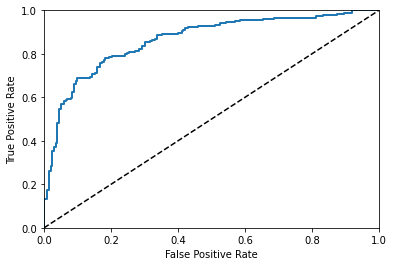

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_train, y_s_4)
plot_roc_curve(fpr, tpr, label = None)

### PROBABILISTIC KERNEL

In [ ]:
def corrected_freq(x, y, i, S):
    resultat = 0
    if x != y:
        resultat = S.loc[x, i] + S.loc[y, i]
    else :
        resultat = S.loc[x, i] + np.log(1 + np.exp(S.loc[x, i]))
    return resultat

In [ ]:
def kernel_freq(a1, b1, S):
    p = -int(S.columns[0])
    m = a1.shape[0]
    n = b1.shape[0]
    A = np.zeros((m, n))
    d = a1.shape[1]
    for i in range(m):
        for j in range(n):
            u = a1[i,:]
            v = b1[j,:]
            resultat = 0
            for k in range(d):
                caractere_1 = alphabet[int(u[k])] 
                caractere_2 = alphabet[int(v[k])]
                resultat = resultat + corrected_freq(caractere_1, caractere_2, k - p, S)
            A[i, j] = np.exp(resultat)
        if(i%100 == 0):
          print("ligne : "+str(i))
    return A

In [ ]:
model_5 = svm.SVC(kernel = lambda x, y: kernel_freq(x, y, S_euk))

La cellule suivante peut prendre du temps à s'executer.

In [ ]:
model_5.fit(Z_train, Y_train)

ligne : 0
ligne : 100
ligne : 200
ligne : 300
ligne : 400


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function <lambda> at 0x7f57f0e74cb0>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
print(classification_report(Y_test, model_5.predict(Z_test)))

ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        49
           1       1.00      0.56      0.72        52

    accuracy                           0.77       101
   macro avg       0.84      0.78      0.76       101
weighted avg       0.85      0.77      0.76       101



La force de ce kernel est sa precision sur les vrais sites, et son recall sur les faux. En effet le tableau ci - dessus s'interprète comme suit : 
*   Parmi ceux que le modèle a prédit comme vrai, 97% sont vrais.
*   Parmi ceux qui sont des faux sites, le modèle a prédit 98% comme faux sites.
 


### COMBINATION

On a décidé d'essayer une combinaison convexe des deux kernels précédents.

In [ ]:
def kernel_mix(a1, b1):
    p = -int(S_euk.columns[0])
    m = a1.shape[0]
    n = b1.shape[0]
    A = np.zeros((m, n))
    d = a1.shape[1]
    for i in range(m):
        for j in range(n):
            u = a1[i,:]
            v = b1[j,:]
            resultat = 0
            for k in range(d):
                caractere_1 = alphabet[int(u[k])] 
                caractere_2 = alphabet[int(v[k])]
                resultat = resultat + corrected_freq(caractere_1, caractere_2, k - p, S_euk)
            A[i, j] = 0.5*np.exp(resultat) + 0.5*similarity(to_letter_array(u), to_letter_array(v))
        if(i%100 == 0):
          print("ligne : "+str(i))
    return A

In [ ]:
model_6 = svm.SVC(kernel = kernel_mix, cache_size = 1000)

In [ ]:
model_6.fit(Z_train, Y_train)

ligne : 0
ligne : 100
ligne : 200
ligne : 300
ligne : 400


SVC(C=1.0, break_ties=False, cache_size=1000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kernel_mix at 0x7f57f0e74ef0>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
print(classification_report(Y_test, model_6.predict(Z_test)))

ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        49
           1       1.00      0.44      0.61        52

    accuracy                           0.71       101
   macro avg       0.81      0.72      0.69       101
weighted avg       0.82      0.71      0.69       101



Ses performances sont très proches de celles du kernel probabilistique.

# SLIDE WINDOW

Etant donné une protéine, cette fonction crée un dataset de sites de cleavage possibles en fonction du voisinage.

In [ ]:
def slide_window(mot, p, q):
    longueur = len(mot)
    dataset = pd.DataFrame(0, index = np.arange(p, longueur - q + 1) - p, 
                           columns = ['Primary structure', 'Indice droit', 'Longueur'])
    for i in range(p, longueur - q+1):
        dataset.loc[i-p, 'Primary structure'] = mot
        dataset.loc[i-p, 'Indice droit'] = i
    dataset['Longueur'] = len(mot)
    return dataset

In [ ]:
def toString(pred, pan):
  print("Les indices droits potentiels pour le cleavage site sont : ")
  n = pred.shape[0]
  cand = []
  if isinstance(pred, pd.DataFrame) :
    for i in range(n):
      if pred.loc[i, 'site'] == 1 :
        print(pan.loc[i, 'Indice droit'])
        cand.append(pan.loc[i,'Indice droit'])
  else :
    for i in range(n):
      if pred[i] == 1 :
        print(pan.loc[i, 'Indice droit'])
        cand.append(pan.loc[i, 'Indice droit'])
  return cand 

Test sur un mot de data_plus.

In [ ]:
mot = data_plus['Primary structure'][35]
label = data_plus['Indice droit'][35]
print("protéine : "+str(mot))
print("indice du cleavage site : "+str(label))

protéine : MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDGTDIV
indice du cleavage site : 20


In [ ]:
slide_window(mot, a, b)

,Primary structure,Indice droit,Longueur
0,MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDG...,13,50
1,MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDG...,14,50
2,MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDG...,15,50
3,MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDG...,16,50
4,MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDG...,17,50
5,MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDG...,18,50
6,MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDG...,19,50
7,MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDG...,20,50
8,MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDG...,21,50
9,MKISIYATLAALSLALPAVAQEGDAAKGEKEFNKCKACHMVQAPDG...,22,50


In [ ]:
pan = slide_window(mot, a, b)
dat = one_hot_matrix(pan, a, b)
w_stat = prediction_statistique(S_euk, a, b, opt, pan)
w1 = model_1.predict(dat)
w2 = model_2.predict(dat)
w3 = model_3.predict(dat)
w4 = model_4.predict(custom(pan,a,b))
w5 = model_5.predict(custom(pan,a,b))
w6 = model_6.predict(custom(pan,a,b))

ligne : 0
ligne : 0
ligne : 0


In [ ]:
toString(w_stat, pan)

Les indices droits potentiels pour le cleavage site sont : 
15
17
18
20
21
22
23
25


[15, 17, 18, 20, 21, 22, 23, 25]

In [ ]:
print("Modele 1")
z = toString(w1, pan)
print("Modele 2")
z = toString(w2, pan)
print("Modele 3")
z = toString(w3, pan)
print("Modele 4")
z = toString(w4, pan)
print("Modele 5")
z = toString(w5, pan)
print("Modele 6")
z = toString(w6, pan)

Modele 1
Les indices droits potentiels pour le cleavage site sont : 
15
20
21
22
23
25
Modele 2
Les indices droits potentiels pour le cleavage site sont : 
15
20
21
23
25
Modele 3
Les indices droits potentiels pour le cleavage site sont : 
15
20
21
22
23
25
Modele 4
Les indices droits potentiels pour le cleavage site sont : 
15
20
21
22
23
25
27
28
Modele 5
Les indices droits potentiels pour le cleavage site sont : 
20
Modele 6
Les indices droits potentiels pour le cleavage site sont : 
20


# **CHOIX DU MODELE : HYPERPARAMETERS TUNING**

## **Classic kernels**

Décommenter et exécuter. Cette cellule prend beaucoup de temps à s'exécuter.

In [ ]:
#"""
for p in [5, 8, 11, 13]:#[5]#range(1, 13):
  for q in [3, 7, 11, 15]:#[7]range(1, 30):
    print("---------------------------------------------------------------------------------------------------")
    print("p = "+str(p)+", q = "+str(q))
    print("---------------------------------------------------------------------------------------------------")
    X_ = build_training(data_euk, p, q)
    X_train_, y_train_ = split(X_)
    C, D, c, d = train_test_split(X_train_, y_train_, test_size = 0.25)
    print("---------------------------------------------------------------------------------------------------")
    print("SVM avec kernel gaussien")
    print("---------------------------------------------------------------------------------------------------")
    model_1_ = gaussian_tune(C, c)
    print(classification_report(d, model_1_.predict(D)))
    print("---------------------------------------------------------------------------------------------------")
    print("SVM avec kernel polynomial")
    print("---------------------------------------------------------------------------------------------------")
    model_2_ = poly_tune(C, c)
    print(classification_report(d, model_2_.predict(D)))
    print("---------------------------------------------------------------------------------------------------")
    print("SVM avec kernel linéaire")
    print("---------------------------------------------------------------------------------------------------")
    model_3_= linear_tune(C, c)
    print(classification_report(d, model_3_.predict(D)))
#"""    

---------------------------------------------------------------------------------------------------
p = 5, q = 3
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   27.4s finished


Best parameters : 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       246
           1       0.86      0.79      0.82       257

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.82       503
weighted avg       0.83      0.83      0.82       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.1min finished


Best parameters : 
{'C': 0.1, 'coef0': 2, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       246
           1       0.87      0.81      0.84       257

    accuracy                           0.84       503
   macro avg       0.84      0.84      0.84       503
weighted avg       0.84      0.84      0.84       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.0s finished


Best parameters : 
{'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       246
           1       0.86      0.80      0.83       257

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.83       503
weighted avg       0.83      0.83      0.83       503

---------------------------------------------------------------------------------------------------
p = 5, q = 7
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   38.2s finished


Best parameters : 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       263
           1       0.88      0.85      0.87       240

    accuracy                           0.87       503
   macro avg       0.88      0.87      0.87       503
weighted avg       0.88      0.87      0.87       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.6min finished


Best parameters : 
{'C': 0.1, 'coef0': 2, 'degree': 3, 'gamma': 0.05, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       263
           1       0.87      0.87      0.87       240

    accuracy                           0.88       503
   macro avg       0.88      0.88      0.88       503
weighted avg       0.88      0.88      0.88       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   33.5s finished


Best parameters : 
{'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       263
           1       0.88      0.88      0.88       240

    accuracy                           0.88       503
   macro avg       0.88      0.88      0.88       503
weighted avg       0.88      0.88      0.88       503

---------------------------------------------------------------------------------------------------
p = 5, q = 11
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   50.2s finished


Best parameters : 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       267
           1       0.79      0.82      0.80       236

    accuracy                           0.81       503
   macro avg       0.81      0.81      0.81       503
weighted avg       0.81      0.81      0.81       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.1min finished


Best parameters : 
{'C': 0.01, 'coef0': 1, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       267
           1       0.79      0.82      0.80       236

    accuracy                           0.81       503
   macro avg       0.81      0.81      0.81       503
weighted avg       0.81      0.81      0.81       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   34.7s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       267
           1       0.78      0.80      0.79       236

    accuracy                           0.80       503
   macro avg       0.80      0.80      0.80       503
weighted avg       0.80      0.80      0.80       503

---------------------------------------------------------------------------------------------------
p = 5, q = 15
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


Best parameters : 
{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       253
           1       0.82      0.86      0.84       250

    accuracy                           0.83       503
   macro avg       0.84      0.84      0.83       503
weighted avg       0.84      0.83      0.83       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.7min finished


Best parameters : 
{'C': 0.01, 'coef0': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       253
           1       0.81      0.83      0.82       250

    accuracy                           0.82       503
   macro avg       0.82      0.82      0.82       503
weighted avg       0.82      0.82      0.82       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   41.7s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       253
           1       0.80      0.86      0.83       250

    accuracy                           0.82       503
   macro avg       0.82      0.82      0.82       503
weighted avg       0.82      0.82      0.82       503

---------------------------------------------------------------------------------------------------
p = 8, q = 3
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   34.9s finished


Best parameters : 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       246
           1       0.85      0.81      0.83       257

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.83       503
weighted avg       0.83      0.83      0.83       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.4min finished


Best parameters : 
{'C': 0.1, 'coef0': 2, 'degree': 3, 'gamma': 0.05, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       246
           1       0.85      0.81      0.83       257

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.83       503
weighted avg       0.83      0.83      0.83       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.4s finished


Best parameters : 
{'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       246
           1       0.84      0.80      0.82       257

    accuracy                           0.82       503
   macro avg       0.82      0.82      0.82       503
weighted avg       0.82      0.82      0.82       503

---------------------------------------------------------------------------------------------------
p = 8, q = 7
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   46.8s finished


Best parameters : 
{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       263
           1       0.86      0.84      0.85       240

    accuracy                           0.86       503
   macro avg       0.86      0.86      0.86       503
weighted avg       0.86      0.86      0.86       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.0min finished


Best parameters : 
{'C': 0.01, 'coef0': 2, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       263
           1       0.85      0.83      0.84       240

    accuracy                           0.85       503
   macro avg       0.85      0.85      0.85       503
weighted avg       0.85      0.85      0.85       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   36.6s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       263
           1       0.86      0.84      0.85       240

    accuracy                           0.86       503
   macro avg       0.86      0.86      0.86       503
weighted avg       0.86      0.86      0.86       503

---------------------------------------------------------------------------------------------------
p = 8, q = 11
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   58.3s finished


Best parameters : 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       254
           1       0.84      0.80      0.82       249

    accuracy                           0.82       503
   macro avg       0.82      0.82      0.82       503
weighted avg       0.82      0.82      0.82       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.4min finished


Best parameters : 
{'C': 1, 'coef0': 1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       254
           1       0.83      0.81      0.82       249

    accuracy                           0.82       503
   macro avg       0.82      0.82      0.82       503
weighted avg       0.82      0.82      0.82       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   37.3s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       254
           1       0.84      0.81      0.83       249

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.83       503
weighted avg       0.83      0.83      0.83       503

---------------------------------------------------------------------------------------------------
p = 8, q = 15
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


Best parameters : 
{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       253
           1       0.86      0.78      0.82       250

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.83       503
weighted avg       0.83      0.83      0.83       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.0min finished


Best parameters : 
{'C': 0.01, 'coef0': 2, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       253
           1       0.86      0.79      0.82       250

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.83       503
weighted avg       0.83      0.83      0.83       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   44.4s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       253
           1       0.86      0.79      0.82       250

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.83       503
weighted avg       0.83      0.83      0.83       503

---------------------------------------------------------------------------------------------------
p = 11, q = 3
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   43.8s finished


Best parameters : 
{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       265
           1       0.85      0.87      0.86       238

    accuracy                           0.86       503
   macro avg       0.86      0.87      0.86       503
weighted avg       0.87      0.86      0.86       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.7min finished


Best parameters : 
{'C': 1, 'coef0': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       265
           1       0.84      0.87      0.86       238

    accuracy                           0.86       503
   macro avg       0.86      0.86      0.86       503
weighted avg       0.86      0.86      0.86       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   26.7s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       265
           1       0.83      0.88      0.86       238

    accuracy                           0.86       503
   macro avg       0.86      0.86      0.86       503
weighted avg       0.86      0.86      0.86       503

---------------------------------------------------------------------------------------------------
p = 11, q = 7
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   56.0s finished


Best parameters : 
{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       269
           1       0.83      0.90      0.87       234

    accuracy                           0.87       503
   macro avg       0.87      0.87      0.87       503
weighted avg       0.87      0.87      0.87       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.2min finished


Best parameters : 
{'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': 0.05, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       269
           1       0.82      0.91      0.86       234

    accuracy                           0.87       503
   macro avg       0.87      0.87      0.87       503
weighted avg       0.87      0.87      0.87       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   34.9s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       269
           1       0.82      0.90      0.86       234

    accuracy                           0.86       503
   macro avg       0.86      0.87      0.86       503
weighted avg       0.87      0.86      0.86       503

---------------------------------------------------------------------------------------------------
p = 11, q = 11
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished


Best parameters : 
{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       260
           1       0.81      0.84      0.82       243

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.82       503
weighted avg       0.83      0.83      0.83       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.8min finished


Best parameters : 
{'C': 1, 'coef0': 1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       260
           1       0.82      0.86      0.84       243

    accuracy                           0.84       503
   macro avg       0.84      0.84      0.84       503
weighted avg       0.84      0.84      0.84       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   40.1s finished


Best parameters : 
{'C': 0.005, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       260
           1       0.81      0.84      0.83       243

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.83       503
weighted avg       0.83      0.83      0.83       503

---------------------------------------------------------------------------------------------------
p = 11, q = 15
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


Best parameters : 
{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       250
           1       0.84      0.85      0.85       253

    accuracy                           0.85       503
   macro avg       0.85      0.85      0.85       503
weighted avg       0.85      0.85      0.85       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.4min finished


Best parameters : 
{'C': 0.01, 'coef0': 1, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       250
           1       0.86      0.87      0.86       253

    accuracy                           0.86       503
   macro avg       0.86      0.86      0.86       503
weighted avg       0.86      0.86      0.86       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   49.1s finished


Best parameters : 
{'C': 0.005, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       250
           1       0.83      0.86      0.85       253

    accuracy                           0.84       503
   macro avg       0.84      0.84      0.84       503
weighted avg       0.84      0.84      0.84       503

---------------------------------------------------------------------------------------------------
p = 13, q = 3
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   49.5s finished


Best parameters : 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       234
           1       0.87      0.88      0.88       269

    accuracy                           0.86       503
   macro avg       0.86      0.86      0.86       503
weighted avg       0.86      0.86      0.86       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.9min finished


Best parameters : 
{'C': 0.1, 'coef0': 2, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       234
           1       0.88      0.89      0.88       269

    accuracy                           0.87       503
   macro avg       0.87      0.87      0.87       503
weighted avg       0.87      0.87      0.87       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   28.3s finished


Best parameters : 
{'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       234
           1       0.87      0.89      0.88       269

    accuracy                           0.87       503
   macro avg       0.87      0.87      0.87       503
weighted avg       0.87      0.87      0.87       503

---------------------------------------------------------------------------------------------------
p = 13, q = 7
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


Best parameters : 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       266
           1       0.86      0.85      0.85       237

    accuracy                           0.86       503
   macro avg       0.86      0.86      0.86       503
weighted avg       0.86      0.86      0.86       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.4min finished


Best parameters : 
{'C': 0.1, 'coef0': 2, 'degree': 2, 'gamma': 0.05, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       266
           1       0.84      0.87      0.86       237

    accuracy                           0.86       503
   macro avg       0.86      0.87      0.86       503
weighted avg       0.87      0.86      0.86       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   34.2s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       266
           1       0.83      0.86      0.84       237

    accuracy                           0.85       503
   macro avg       0.85      0.85      0.85       503
weighted avg       0.85      0.85      0.85       503

---------------------------------------------------------------------------------------------------
p = 13, q = 11
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


Best parameters : 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       249
           1       0.84      0.79      0.82       254

    accuracy                           0.82       503
   macro avg       0.82      0.82      0.82       503
weighted avg       0.82      0.82      0.82       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.0min finished


Best parameters : 
{'C': 0.01, 'coef0': 2, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       249
           1       0.87      0.83      0.85       254

    accuracy                           0.85       503
   macro avg       0.85      0.85      0.85       503
weighted avg       0.85      0.85      0.85       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   43.4s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       249
           1       0.86      0.83      0.85       254

    accuracy                           0.85       503
   macro avg       0.85      0.85      0.85       503
weighted avg       0.85      0.85      0.85       503

---------------------------------------------------------------------------------------------------
p = 13, q = 15
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
SVM avec kernel gaussien
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


Best parameters : 
{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       249
           1       0.84      0.81      0.82       254

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.83       503
weighted avg       0.83      0.83      0.83       503

---------------------------------------------------------------------------------------------------
SVM avec kernel polynomial
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.6min finished


Best parameters : 
{'C': 0.01, 'coef0': 2, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       249
           1       0.85      0.84      0.84       254

    accuracy                           0.84       503
   macro avg       0.84      0.84      0.84       503
weighted avg       0.84      0.84      0.84       503

---------------------------------------------------------------------------------------------------
SVM avec kernel linéaire
---------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   50.5s finished


Best parameters : 
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       249
           1       0.85      0.84      0.84       254

    accuracy                           0.84       503
   macro avg       0.84      0.84      0.84       503
weighted avg       0.84      0.84      0.84       503



Le meilleur modèle gaussien pour $(p, q) \in [5, 8, 11, 13]*[3, 7, 11, 15, 20, 25, 30]$ est celui pour lequel $p = 11, q = 7$. On a pu remarquer que les larges voisinages ne permettaient pas d'obtenir les meilleurs résultats. On pourrait affiner la recherche en se limitant à $q \leq 15$ par exemple.

In [ ]:
alpha, beta = split(build_training(data_euk, 11, 7))
best = gaussian_tune(alpha, beta)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.7min finished


Best parameters : 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
toString(best.predict(one_hot_matrix(slide_window(mot, 11, 7),11, 7)), slide_window(mot, 11, 7))

Les indices droits potentiels pour le cleavage site sont : 
15
20
23
25


[15, 20, 23, 25]

## **Customized kernels**

Décommenter et exécuter. Cette cellule prend beaucoup de temps à s'exécuter.

In [ ]:
#"""
for p in [3, 5, 9, 11]:
  for q in [3, 7, 9, 11, 13]:
    print("---------------------------------------------------------------------------------------------------")
    print("p = "+str(p)+", q = "+str(q))
    print("---------------------------------------------------------------------------------------------------")
    L = total_custom(data_euk, p, q)
    L = L[L.index <= 250]
    S__ = preprocessing(data_euk, p, q)
    X_ent, y_ent = split(L)
    C, D, c, d = train_test_split(X_ent, y_ent, test_size = 0.2)
    print("---------------------------------------------------------------------------------------------------")
    print("PROBABILISTIC")
    print("---------------------------------------------------------------------------------------------------")
    mod1 = svm.SVC(kernel = lambda x, y : kernel_freq(x, y, S__)) 
    mod1.fit(C, c)
    res1 = mod1.predict(D)
    print(classification_report(d, res1))
    print("---------------------------------------------------------------------------------------------------")
    print("BLOSUM62")
    print("---------------------------------------------------------------------------------------------------")
    mod2 = svm.SVC(kernel = kernel_z)
    mod2.fit(C, c)
    res2 = mod2.predict(D)
    print(classification_report(d, res2))
#"""

---------------------------------------------------------------------------------------------------
p = 3, q = 3
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
PROBABILISTIC
---------------------------------------------------------------------------------------------------
ligne : 0
ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        51

    accuracy                           0.86       101
   macro avg       0.87      0.86      0.86       101
weighted avg       0.87      0.86      0.86       101

---------------------------------------------------------------------------------------------------
BLOSUM62
---------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        50
           1       0.78      0.71      0.74        51

    accuracy                           0.75       101
   macro avg       0.75      0.75      0.75       101
weighted avg       0.76      0.75      0.75       101

---------------------------------------------------------------------------------------------------
p = 5, q = 3
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
PROBABILISTIC
---------------------------------------------------------------------------------------------------
ligne : 0
ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.89      0.96      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.76      0.71      0.73        52
           1       0.71      0.76      0.73        49

    accuracy                           0.73       101
   macro avg       0.73      0.73      0.73       101
weighted avg       0.73      0.73      0.73       101

---------------------------------------------------------------------------------------------------
p = 9, q = 3
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
PROBABILISTIC
---------------------------------------------------------------------------------------------------
ligne : 0
ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.70      0.98      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        60
           1       0.77      0.80      0.79        41

    accuracy                           0.82       101
   macro avg       0.81      0.82      0.82       101
weighted avg       0.82      0.82      0.82       101

---------------------------------------------------------------------------------------------------
p = 9, q = 13
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
PROBABILISTIC
---------------------------------------------------------------------------------------------------
ligne : 0
ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.47      1.00      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.85      0.77      0.80        43
           1       0.84      0.90      0.87        58

    accuracy                           0.84       101
   macro avg       0.84      0.83      0.84       101
weighted avg       0.84      0.84      0.84       101

---------------------------------------------------------------------------------------------------
p = 11, q = 13
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
PROBABILISTIC
---------------------------------------------------------------------------------------------------
ligne : 0
ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.51      1.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 0
ligne : 100
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        52
           1       0.73      0.84      0.78        49

    accuracy                           0.77       101
   macro avg       0.78      0.77      0.77       101
weighted avg       0.78      0.77      0.77       101



Les meilleurs paramètres pour le kernel probabilistique sont $p = 5, q = 3$.

In [ ]:
S_prime = preprocessing(data_euk, 5, 3)
M_prime = total_custom(data_euk, 5, 3)
M_prime = M_prime[M_prime.index <= 500]
U, V = split(M_prime)
mode = svm.SVC(kernel = lambda x, y : kernel_freq(x, y, S_prime))
mode.fit(U, V)

ligne : 0
ligne : 100
ligne : 200
ligne : 300
ligne : 400
ligne : 500
ligne : 600
ligne : 700
ligne : 800
ligne : 900
ligne : 1000


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function <lambda> at 0x7f57f0de03b0>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

l'on test si pour les proteines du dataset GRAM+, l'indice effectif du Cleavage site est inclus dans les sites potentiels predits par le classifieur.

In [ ]:
cardinal = 0
for i in range(data_plus.shape[0]):
  mot_ = data_plus.loc[i, 'Primary structure']
  ind = data_plus.loc[i, 'Indice droit']
  print("---------------------------------------------------------------------------------------------------")
  print("Protéine : "+mot_)
  print("Cleavage site : "+str(ind))
  print("---------------------------------------------------------------------------------------------------")
  candidats = slide_window(mot_, 5, 3)
  z = toString(mode.predict(custom(candidats, 5, 3)), candidats)
  if ind in z :
    cardinal = cardinal + 1

print(cardinal/data_plus.shape[0])

Pour predire le cleavage site pour une protéine donnée on pourrait utiliser plusieurs classifieurs et procéder à un vote (choisir la position qui revient le plus souvent). On peut aussi donner des poids différents.